In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
import keras
import keras.layers as ll
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
%matplotlib inline

Using TensorFlow backend.


In [3]:
tf_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True), log_device_placement=True)

In [4]:
in_columns = ['S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0']
out_columns = ['0', '1', '2']
IN_DIM = len(in_columns)
OUT_DIM = len(out_columns)

In [5]:
BATCH_SIZE = int(1e3)
LATENT_DIMENSIONS = 3
TEST_SIZE = 0.3

In [7]:
def split_and_scale(data):
    data_train, data_val = train_test_split(data, test_size=TEST_SIZE, random_state=42)
    data_val, data_test = train_test_split(data_val, test_size=TEST_SIZE, random_state=1812)
    
    pid_train = np.array(data_train["pid"])
    pid_val = np.array(data_val["pid"])
    pid_test = np.array(data_test["pid"])
    
    data_train.drop("pid", axis=1, inplace=True)
    data_val.drop("pid", axis=1, inplace=True)
    data_test.drop("pid", axis=1, inplace=True)
    
    scaler = RobustScaler().fit(data_train)
    data_train = pd.DataFrame(scaler.transform(data_train.values),
                              columns=data_train.columns)
    data_val = pd.DataFrame(scaler.transform(data_val.values),
                            columns=data_val.columns)
    data_test = pd.DataFrame(scaler.transform(data_test.values),
                            columns=data_test.columns)
    
    data_train["pid"] = pid_train
    data_val["pid"] = pid_val
    data_test["pid"] = pid_test
    
    return data_train, data_val, data_test

In [8]:
data_all_pids = pd.read_csv("./LHCb_PID_Compression/df_full_encoded_ratio10_new_3.csv").drop('Unnamed: 0', axis=1)
data_train, data_val, data_test = split_and_scale(data_all_pids)

/mnt/tgaintseva/conda/envs/py3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [9]:
data_test.head()

,0,1,2,S0aux7,S0aux6,S3aux0,S2aux0,S5aux0,pid
0,0.908738,-0.450913,0.385632,-0.492425,0.066989,-1000.0,-1000.0,0.0,d
1,-0.690827,-0.579185,-0.286361,0.069803,-0.181690,0.0,0.0,0.0,d
2,0.486527,-0.044550,-0.332445,-0.343919,-0.129153,0.0,0.0,0.0,b
3,-0.121902,0.254168,-0.362381,0.888505,0.034761,0.0,0.0,0.0,f
4,-0.020486,-1.635658,0.609600,-0.249726,1.057243,0.0,0.0,-1000.0,d


In [10]:
data_test.to_csv("data_test_full_scaled.csv")

In [11]:
len(data_test)

1194189

## XGBoost for PID Classification

In [6]:
from helpers import *

Prepare data:

after GAN:

In [7]:
data_test_pid_a = np.array(pd.read_csv('./saved_dfs/df_GAN_dim3_scaled_pid{}.csv'.format('a')))
data_test_pid_b = np.array(pd.read_csv('./saved_dfs/df_GAN_dim3_scaled_pid{}.csv'.format('b')))
data_test_pid_f = np.array(pd.read_csv('./saved_dfs/df_GAN_dim3_scaled_pid{}.csv'.format('f')))
data_test_pid_d = np.array(pd.read_csv('./saved_dfs/df_GAN_dim3_scaled_pid{}.csv'.format('d')))
data_test_pid_e = np.array(pd.read_csv('./saved_dfs/df_GAN_dim3_scaled_pid{}.csv'.format('e')))

data_test = np.concatenate([data_test_pid_a, data_test_pid_b, data_test_pid_d, data_test_pid_e, data_test_pid_f], axis=0)
data_test = pd.DataFrame(data_test, columns=out_columns+in_columns+['pid'])
data_test.head()

,0,1,2,S0aux7,S0aux6,S3aux0,S2aux0,S5aux0,pid
0,1.24656,-0.362378,1.97745,-0.440529,-0.229974,-1000,-1000,0,a
1,-0.406903,-0.0703107,0.603557,-0.043711,-0.809865,0,0,0,a
2,-0.295933,-0.0445392,0.70592,0.238293,-0.846499,0,0,0,a
3,-0.530556,-0.0446532,0.617528,-0.0297662,-0.622294,0,0,0,a
4,0.563867,0.136238,0.406715,-0.0354277,0.829413,0,0,-1000,a


orig

In [8]:
data_test_orig = pd.read_csv("data_test_full_scaled.csv")
data_test_orig.head()

,Unnamed: 0,0,1,2,S0aux7,S0aux6,S3aux0,S2aux0,S5aux0,pid
0,0,0.908738,-0.450913,0.385632,-0.492425,0.066989,-1000.0,-1000.0,0.0,d
1,1,-0.690827,-0.579185,-0.286361,0.069803,-0.181690,0.0,0.0,0.0,d
2,2,0.486527,-0.044550,-0.332445,-0.343919,-0.129153,0.0,0.0,0.0,b
3,3,-0.121902,0.254168,-0.362381,0.888505,0.034761,0.0,0.0,0.0,f
4,4,-0.020486,-1.635658,0.609600,-0.249726,1.057243,0.0,0.0,-1000.0,d


In [9]:
data_test_input = data_test[in_columns]
data_test_out = data_test[out_columns]
data_test_full = data_test[in_columns+out_columns]
pid_test = data_test["pid"]

In [12]:
pid_test_orig = data_test_orig["pid"]

Split to train/test for xgboost:

In [10]:
len(data_test_orig)

1194189

In [13]:
le = LabelEncoder()
y = le.fit_transform(pid_test)

In [14]:
y_orig = le.transform(pid_test_orig)

In [15]:
test_size = 0.1

idx_train_clf, idx_test_clf = train_test_split(np.arange(data_test_full.shape[0]), stratify=y, 
                                               random_state=42, test_size=test_size)
X_train, X_test = np.array(data_test_out)[idx_train_clf], np.array(data_test_out)[idx_test_clf]
X_train_gen, X_test_gen = np.array(data_test_orig[out_columns])[idx_train_clf], np.array(data_test_orig[out_columns])[idx_test_clf]
y_train, y_test = y[idx_train_clf], y[idx_test_clf]
y_train_gen, y_test_gen = y_orig[idx_train_clf], y_orig[idx_test_clf]

In [16]:
X_train.shape

(1074770, 3)

In [17]:
metrics_dict = {
    # ROC
    'fpr': defaultdict(dict),
    'tpr': defaultdict(dict),
    'roc_auc': defaultdict(dict),

    # PR
    'precision': defaultdict(dict), 
    'recall': defaultdict(dict),
    'pr_auc': defaultdict(dict),

    'f_measure': {},
    'acc': {}
}

In [18]:
path_to_metrics = './metrics/'
metrics_dir_name = "GAN_XGB"

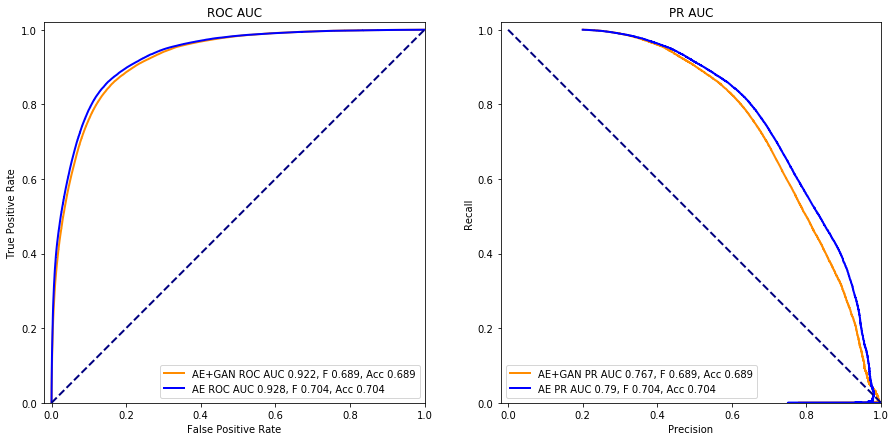

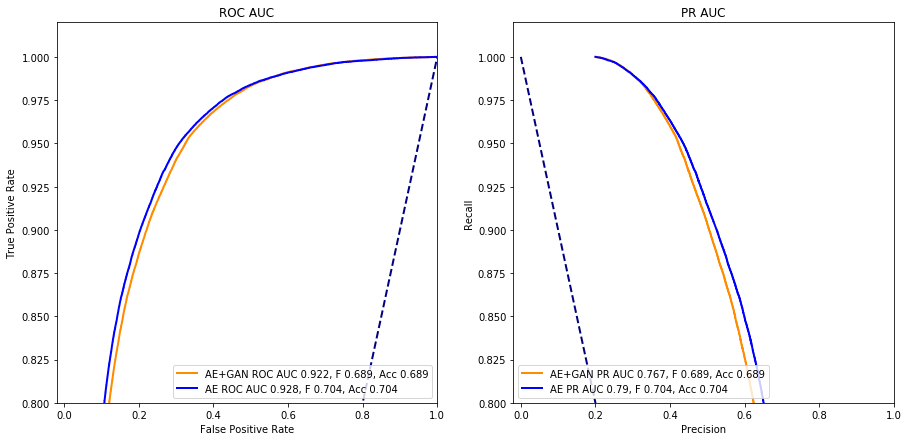

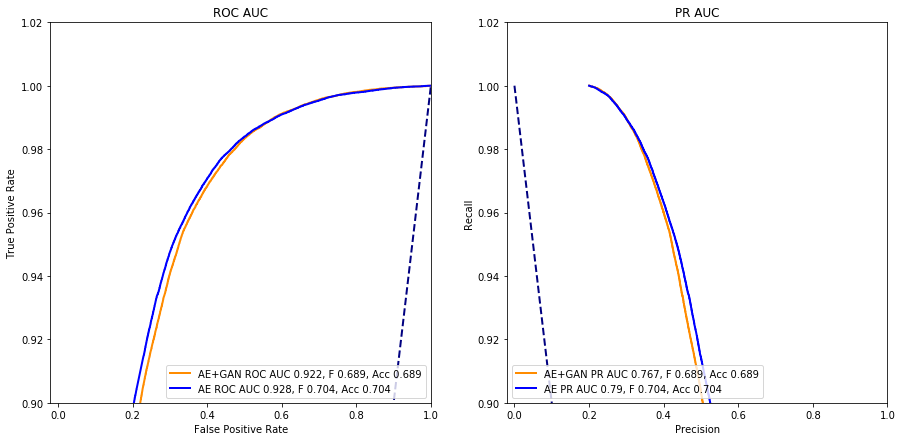

100%|██████████| 2/2 [11:21<00:00, 340.99s/it]


In [19]:
from tqdm import tqdm
for encoding_dim in tqdm(["AE+GAN", "AE"]):
    clf_name = "XGBoost_{}".format(encoding_dim)
    clf = xgb.XGBClassifier(nthread=-1, seed=111)
    
    if encoding_dim == "AE":
        clf.fit(X_train_gen, y_train_gen)
        y_proba = clf.predict_proba(X_test_gen)
        y = y_test_gen
    else:
        clf.fit(X_train, y_train)
        y_proba = clf.predict_proba(X_test)
        y = y_test
    y_bin = label_binarize(y, classes=np.unique(y))
    y_pred = np.argmax(y_proba, axis=1)
    
    # Compute ROC/PR curve and ROC/PR area for each class
    for pid_label in np.unique(y):
        idx = np.where(y == pid_label)[0]
        cur_y = np.where(y == pid_label, np.ones_like(y), np.zeros_like(y))
        cur_y_proba = y_proba[:, pid_label]
        
        pid_label = str(pid_label)
        metrics_dict['fpr'][encoding_dim][pid_label], metrics_dict['tpr'][encoding_dim][pid_label], _ = \
            roc_curve(cur_y, cur_y_proba)
        metrics_dict['precision'][encoding_dim][pid_label], metrics_dict['recall'][encoding_dim][pid_label], _ = \
            precision_recall_curve(cur_y, cur_y_proba)
        
    metrics_dict['fpr'][encoding_dim]["micro"], metrics_dict['tpr'][encoding_dim]["micro"], _ = \
        roc_curve(y_bin.ravel(), y_proba.ravel())
    metrics_dict['precision'][encoding_dim]["micro"], metrics_dict['recall'][encoding_dim]["micro"], _ = \
        precision_recall_curve(y_bin.ravel(), y_proba.ravel())
    
    metrics_dict['roc_auc'][encoding_dim]["micro"] = auc(
        metrics_dict['fpr'][encoding_dim]["micro"], metrics_dict['tpr'][encoding_dim]["micro"])
    metrics_dict['pr_auc'][encoding_dim]["micro"] = average_precision_score(y_bin.ravel(), y_proba.ravel())
    
    metrics_dict['f_measure'][encoding_dim] = f1_score(y, y_pred, average='micro')
    metrics_dict['acc'][encoding_dim] = accuracy_score(y, y_pred)
    
    # Save
    dump_metrics(path_to_metrics, metrics_dir_name, metrics_dict)
    
    # Plot
    display.clear_output(wait=True)
    plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0, 1.02))
    plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0.8, 1.02))
    plot_metrics(metrics_dict, pid_label='micro', xlim=(-0.02, 1), ylim=(0.9, 1.02))